(224, 224, 3)


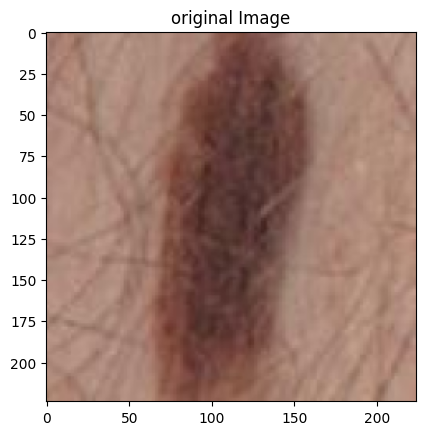

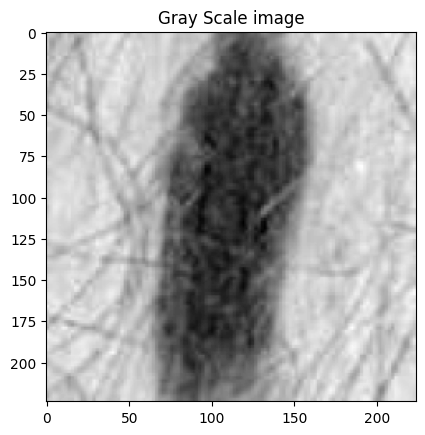

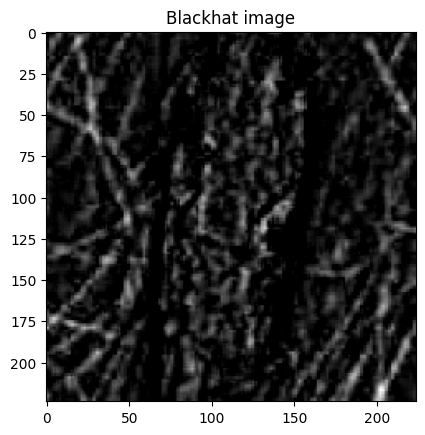

(224, 224)


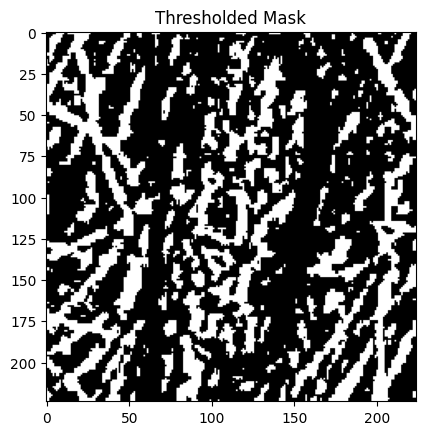

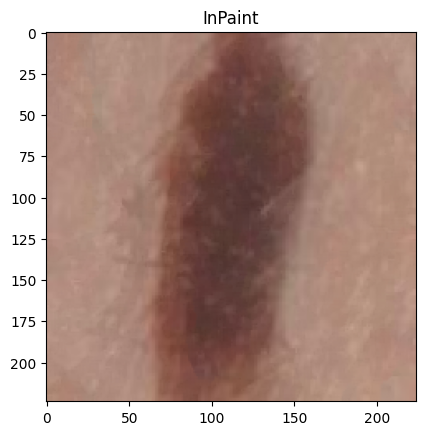

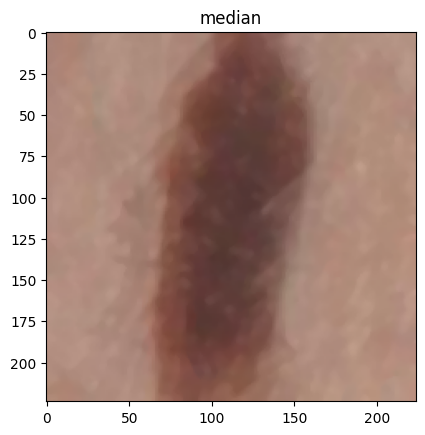

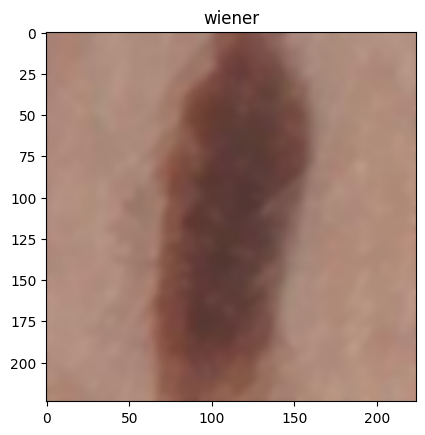

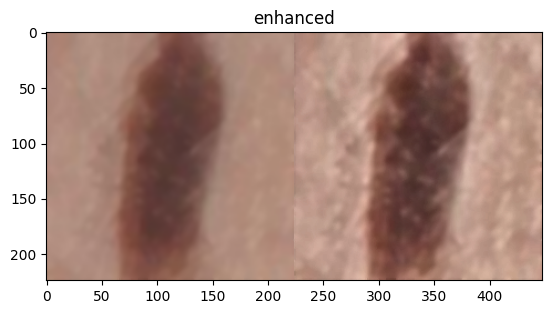

In [3]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np 
from scipy.signal import wiener

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the dimensions
        r = width / float(w)
        if (h * r) < 224:
            dim = (width, math.ceil(h * r))
        else:
            dim = (width, math.floor(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

def show_image(image_name, img):
    b,g,r = cv2.split(img) 
    rgb_img1 = cv2.merge([r,g,b])
    plt.imshow(rgb_img1)
    plt.title(image_name)
    plt.show()

img1 = "/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0052109.jpg"

# Open the image using PIL
img = cv2.imread(img1)

# Resize the image to 224 x 224
image_res = image_resize(img, width = 224, height = 224)

print( image_res.shape )
show_image("original Image",image_res)

# Convert the original image to grayscale
grayScale = cv2.cvtColor(image_res, cv2.COLOR_RGB2GRAY )
plt.imshow(grayScale, cmap='gray')
plt.title("Gray Scale image")
plt.show()

# Kernel for the morphological filtering
kernel = cv2.getStructuringElement(1,(17,17))

# Perform the blackHat filtering on the grayscale image to find the hair countours
blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
plt.imshow(blackhat, cmap='gray')
plt.title("Blackhat image")
plt.show()

# Intensify the hair countours in preparation for the inpainting algorithm
ret,thresh2 = cv2.threshold(blackhat,5,255,cv2.THRESH_BINARY)
print( thresh2.shape )
plt.imshow(thresh2, cmap='gray')
plt.title("Thresholded Mask")
plt.show()

# Inpaint the original image depending on the mask
dst = cv2.inpaint(image_res,thresh2,1,cv2.INPAINT_TELEA)
show_image("InPaint",dst)

# Apply median filter
median = cv2.medianBlur(dst,5)
show_image("median",median)

# Wiener filter
def apply_wiener_filter(img):
    # Convert to float32 for filtering
    img_float = np.float32(img)
    # Apply Wiener filter (assuming a 3x3 filter size)
    filtered_img = (wiener(img_float, (5, 5)))
    return np.uint8(filtered_img)

# Split into R, G, B channels
b_channel, g_channel, r_channel = cv2.split(median)

# Apply Wiener filter to each channel
b_filtered = apply_wiener_filter(b_channel)
g_filtered = apply_wiener_filter(g_channel)
r_filtered = apply_wiener_filter(r_channel)

# Merge channels back
filtered_color_img = cv2.merge([b_filtered, g_filtered, r_filtered])
show_image("wiener",filtered_color_img)

# Converting to LAB color space
lab= cv2.cvtColor(filtered_color_img, cv2.COLOR_BGR2LAB)
l_channel, a, b = cv2.split(lab)

# Applying CLAHE to L-channel
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl = clahe.apply(l_channel)

# Merge the CLAHE enhanced L-channel with the a and b channel
limg = cv2.merge((cl,a,b))

# Converting image from LAB Color model to BGR color spcae
enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

# Stacking the original image with the enhanced image
result = np.hstack((filtered_color_img, enhanced_img))
show_image("enhanced",result)